✅ Using your dataset at: Mall_Customers.csv
First 5 rows:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Using 4 numeric features, 200 rows.
PCA explained variance (2D): [0.495 0.331]


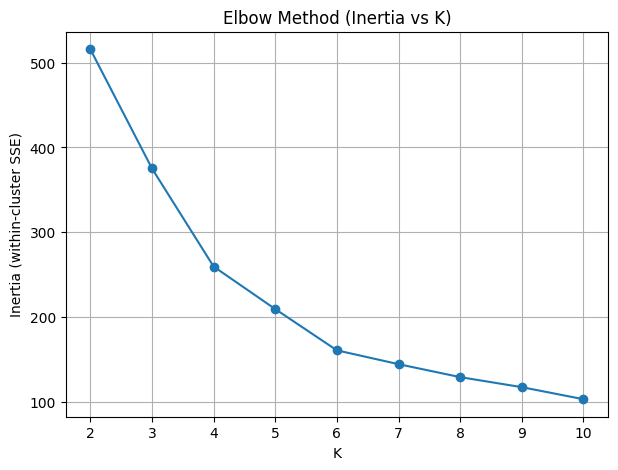

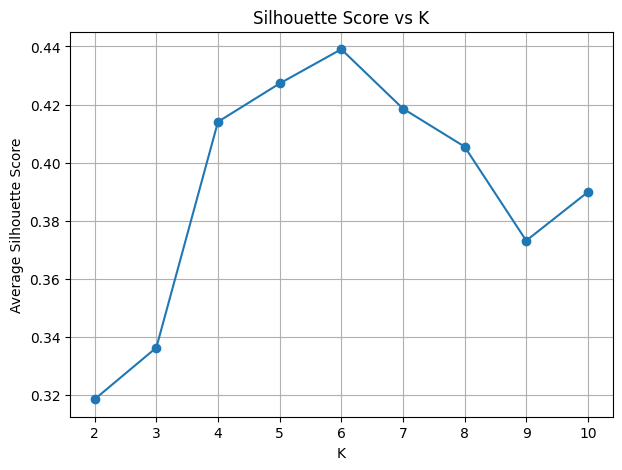

🧠 Suggested K (by max silhouette): 6  | Scores: {2: np.float64(0.319), 3: np.float64(0.336), 4: np.float64(0.414), 5: np.float64(0.427), 6: np.float64(0.439), 7: np.float64(0.419), 8: np.float64(0.405), 9: np.float64(0.373), 10: np.float64(0.39)}


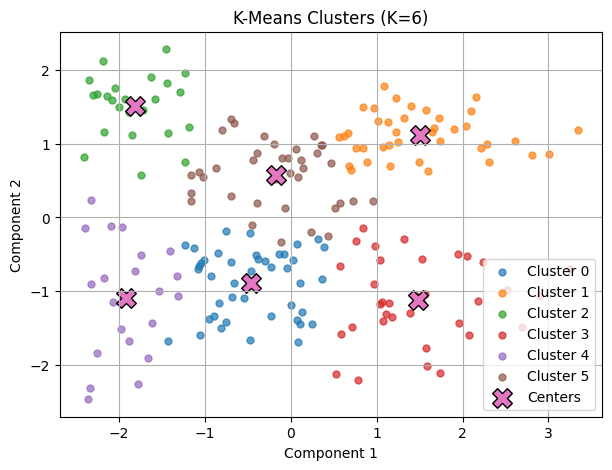

✅ Final Silhouette Score (higher is better): 0.439
📁 Saved labeled data to: clustered_data.csv

Cluster sizes:
cluster
0    44
1    39
2    24
3    35
4    21
5    37
Name: count, dtype: int64

Cluster means (numeric features):
         CustomerID    Age  Annual Income (k$)  Spending Score (1-100)
cluster                                                               
0             82.02  56.34               53.70                   49.39
1            162.00  32.69               86.54                   82.13
2             23.04  25.25               25.83                   76.92
3            164.43  41.69               88.23                   17.29
4             23.19  45.52               26.29                   19.38
5             91.30  26.89               57.14                   48.81


In [1]:
# =========================
# Step 0: Install libraries (run once)
# =========================
# If you see "ModuleNotFoundError", uncomment and run these:
# !pip install pandas scikit-learn matplotlib

# =========================
# Step 1: Imports
# =========================
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# For a clean look in plots
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

# =========================
# Step 2: Load dataset
# =========================
# Change this to your CSV path if needed:
DATASET_PATH = "Mall_Customers.csv"

def load_data(path):
    if os.path.exists(path):
        print(f"✅ Using your dataset at: {path}")
        df = pd.read_csv(path)
    else:
        print("⚠️ Dataset not found. Generating a synthetic dataset so the code can run without errors.")
        from sklearn.datasets import make_blobs
        X, _ = make_blobs(n_samples=200, centers=4, n_features=4, cluster_std=1.2, random_state=42)
        df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
    return df

df = load_data(DATASET_PATH)
print("First 5 rows:")
display(df.head())

# =========================
# Step 3: Select numeric features & basic cleaning
# =========================
# If you know exactly which columns to use, list them here:
# e.g., for Mall Customers: cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
cols = None  # keep None to auto-pick numeric columns

if cols is None:
    X = df.select_dtypes(include=[np.number]).copy()
else:
    X = df[cols].copy()

# Drop rows with missing values in selected features
X = X.dropna()
print(f"Using {X.shape[1]} numeric features, {X.shape[0]} rows.")

# =========================
# Step 4: Scale features
# =========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# Step 5 (Optional): PCA to 2D for visualization
# =========================
use_pca_for_plot = X_scaled.shape[1] > 2
if use_pca_for_plot:
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X_scaled)
    print("PCA explained variance (2D):", pca.explained_variance_ratio_.round(3))
else:
    # If already 2D, just use the scaled features for plotting
    X_2d = X_scaled[:, :2]

# =========================
# Step 6: Find optimal K (Elbow & Silhouette)
# =========================
Ks = range(2, 11)  # try K = 2..10
inertias = []
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot Elbow
plt.figure()
plt.plot(Ks, inertias, marker="o")
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("K")
plt.ylabel("Inertia (within-cluster SSE)")
plt.show()

# Plot Silhouette
plt.figure()
plt.plot(Ks, sil_scores, marker="o")
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Average Silhouette Score")
plt.show()

# Choose K with best silhouette (simple automatic pick)
best_k = Ks[int(np.argmax(sil_scores))]
print(f"🧠 Suggested K (by max silhouette): {best_k}  | Scores: {dict(zip(Ks, np.round(sil_scores,3)))}")

# =========================
# Step 7: Fit final K-Means and label data
# =========================
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
df_clusters = X.copy()
df_clusters["cluster"] = cluster_labels

# =========================
# Step 8: Visualize clusters in 2D
# =========================
# Get cluster centers in 2D plot space
if use_pca_for_plot:
    centers_2d = pca.transform(kmeans.cluster_centers_)
else:
    centers_2d = kmeans.cluster_centers_[:, :2]

plt.figure()
for c in range(best_k):
    pts = X_2d[cluster_labels == c]
    plt.scatter(pts[:, 0], pts[:, 1], s=25, alpha=0.7, label=f"Cluster {c}")
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], s=200, marker="X", edgecolor="k", label="Centers")
plt.title(f"K-Means Clusters (K={best_k})")
plt.xlabel("Component 1" if use_pca_for_plot else "Feature 1")
plt.ylabel("Component 2" if use_pca_for_plot else "Feature 2")
plt.legend()
plt.show()

# =========================
# Step 9: Evaluate clustering
# =========================
final_sil = silhouette_score(X_scaled, cluster_labels)
print(f"✅ Final Silhouette Score (higher is better): {final_sil:.3f}")

# =========================
# Step 10: Save labeled data and view cluster profiles
# =========================
out_path = "clustered_data.csv"
df_out = df.copy()
df_out = df_out.loc[X.index]  # align indices if rows were dropped
df_out["cluster"] = cluster_labels
df_out.to_csv(out_path, index=False)
print(f"📁 Saved labeled data to: {out_path}")

print("\nCluster sizes:")
print(df_out["cluster"].value_counts().sort_index())

print("\nCluster means (numeric features):")
print(df_out.groupby("cluster").mean(numeric_only=True).round(2))
